In [10]:
import numpy as np
import os, re, shutil
import ROOT as rt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from root_numpy import root2array
from lib.histo_utilities import create_TH1D, create_TH2D
from lib.cebefo_style import cebefo_style

In [11]:
cebefo_style()

In [12]:
input_file = '../data/test_Run768.root'
validation_file = '../data/test_Run769.root'
ch = 14

In [13]:
data = root2array(input_file)

In [14]:
canvas = {}
canvas['amp'] = {}
canvas['int'] = {}
canvas['wave'] = {}
canvas['pos'] = {}
canvas['w_pos'] = {}

info = {ch: {}, 9:{}}

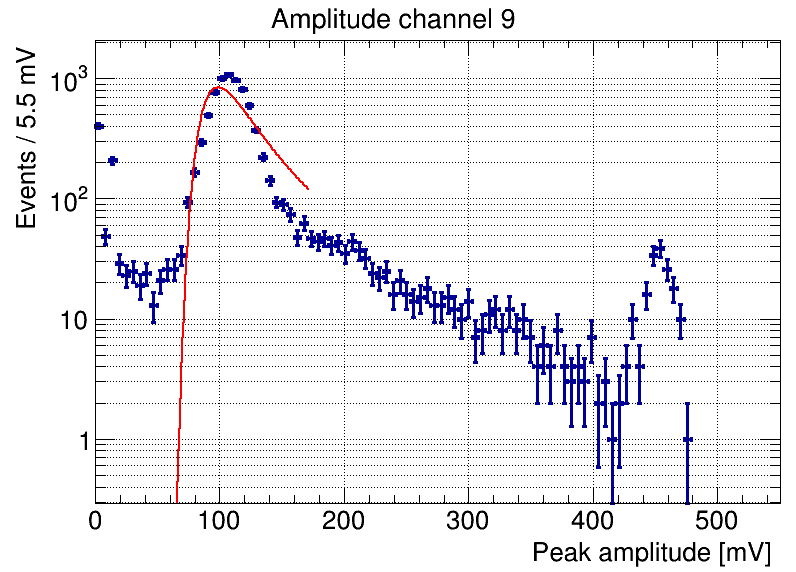

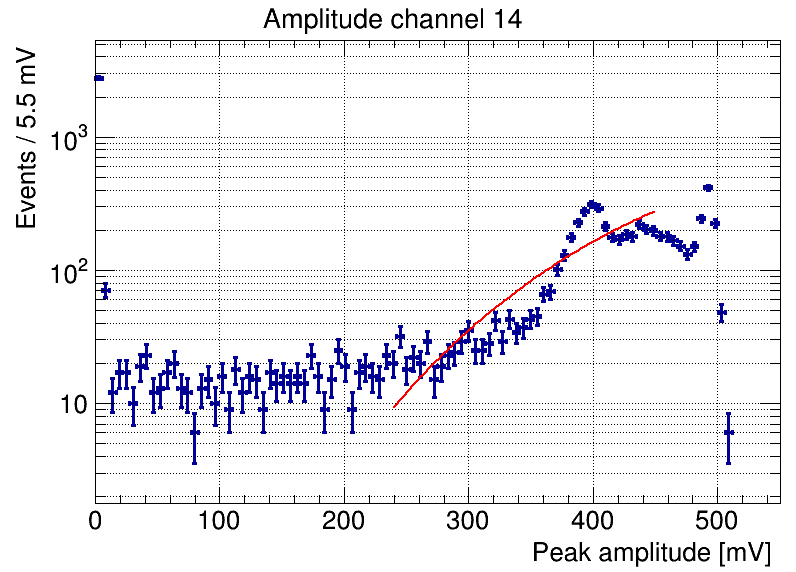

In [15]:
for k in [9, ch]:
    
    '''=========================== Amplitude ==========================='''
    canvas['amp'][k] = rt.TCanvas('c_amp_'+str(k), 'c_amp_'+str(k), 800, 600)
    
    name = 'h_amp_'+str(k)
    title = 'Amplitude channel '+str(k)
    amp = (data['amp'].T)[k]
    h = create_TH1D(amp, name, title, 
                    binning = [100, 0, 550],
                    axis_title = ['Peak amplitude [mV]', 'Events / 5.5 mV'])
            
    h.GetXaxis().SetRange(int(40/5.5)+1,int(450/5.5)+1)
    i_max = h.GetMaximumBin()
    h.GetXaxis().SetRange(1,100)
    peak = h.GetBinCenter(i_max)
    info[k]['amp_range'] = [max(20,peak*0.6), min(450, peak*1.6)]
    res = h.Fit('landau','LQSR', '', info[k]['amp_range'][0], info[k]['amp_range'][1])
    h.SetStats(0)
    
    if(h.GetMaximum() - h.GetMinimum() > 1000):
        canvas['amp'][k].SetLogy()
    h.DrawCopy('E1')
    canvas['amp'][k].Update()    
    canvas['amp'][k].Draw()

In [16]:
def create_sample(input_file, selection):
    data = root2array(input_file, selection=selection)
    amp = (data['amp'].T)[ch]

#     risetime = (data['LP2_90'].T)[ch] - (data['LP2_10'].T)[ch]

    x_pos = (data['x_dut'].T)[0]
    y_pos = (data['y_dut'].T)[0]
    
    decay_time = (data['decaytime'].T)[ch]
    
    integral = (data['integral'].T)[ch]


    x_train = np.column_stack((amp, integral, decay_time, x_pos, y_pos))

    time_stamp = (data['LP2_10'].T)[ch]
    time_ref = (data['gaus_mean'].T)[9]
    
    y_train = time_stamp - time_ref
    
    return x_train, y_train

In [17]:
selection = 'amp[9]>50 && amp[9]<200 && amp['+str(ch)+']>300 && amp['+str(ch)+']<460 && x_dut[0]>-99 && y_dut[0]>-99'
selection += ' && (LP2_10['+str(ch)+'] - gaus_mean[9]) >-11 && (LP2_10['+str(ch)+'] - gaus_mean[9]) < -10'

x_train, y_train = create_sample(input_file, selection)
print x_train.shape

(2927, 5)


In [39]:
gbr = GradientBoostingRegressor(loss='ls',
                                n_estimators=1000, max_depth=3,
                                learning_rate=.2, min_samples_leaf=20,
                                min_samples_split=20,
                                verbose=0
                                )

# gbr = SVR(C=2, epsilon= )

# gbr = MLPRegressor(hidden_layer_sizes=(100,50,30),
#                    activation='tanh',
#                    learning_rate='adaptive',
#                    solver='sgd',
#                    verbose=2
#                   )

gbr.fit(x_train, y_train)
y_train_pred = gbr.predict(x_train)

Post:  40.4303556217
Pre:  100.713201467


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_train
Warning in <TROOT::Append>: Replacing existing TH1: h_train (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_train (Potential memory leak).


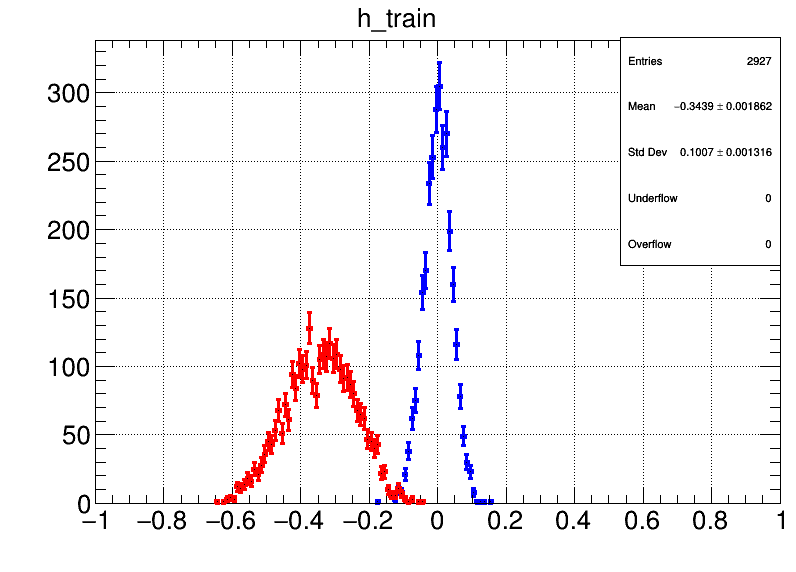

In [40]:
canvas = rt.TCanvas('c_train', 'c_train', 800, 600)

h = create_TH1D(y_train - y_train_pred, 'h_train', 'h_train', binning=[200,-1,1])
h.SetLineColor(4)
print 'Post: ',1000*h.GetRMS()
h.DrawCopy('E1')

h = create_TH1D(y_train+10, 'h_train', 'h_train', binning=[200,-1,1])
h.SetLineColor(2)
print 'Pre: ',1000*h.GetRMS()
h.DrawCopy('E1SAMES')

canvas.Draw()

(2071, 5)
Post:  71.7703383245
Pre:  100.56012073


Warning in <TROOT::Append>: Replacing existing TH1: h_val (Potential memory leak).


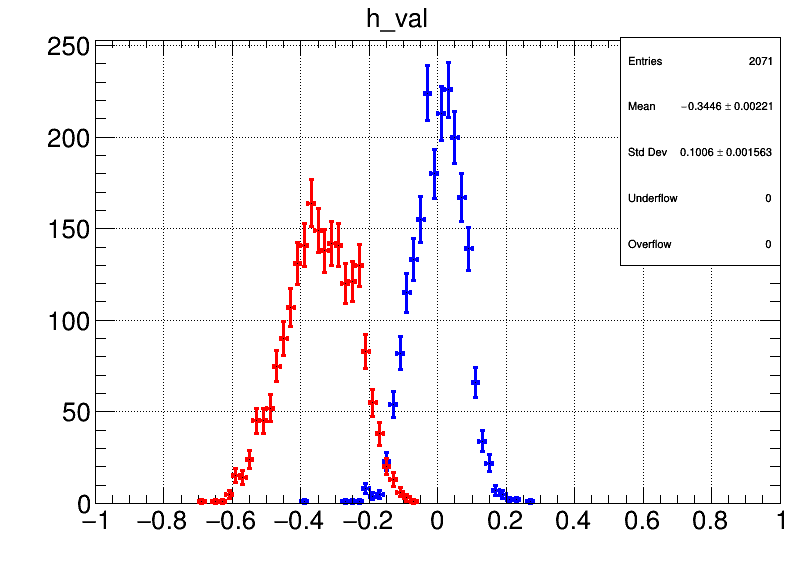

In [41]:
x_val, y_val = create_sample(validation_file, selection)
print x_val.shape

y_val_pred = gbr.predict(x_val)

canvas = rt.TCanvas('c_val', 'c_val', 800, 600)

h = create_TH1D(y_val - y_val_pred, 'h_val', 'h_val', binning=[100,-1,1])
h.SetLineColor(4)
print 'Post: ',1000*h.GetRMS()
h.DrawCopy('E1')


h = create_TH1D(y_val+10, 'h_val', 'h_val', binning=[100,-1,1])
h.SetLineColor(2)
print 'Pre: ',1000*h.GetRMS()
h.DrawCopy('E1SAMES')



canvas.Draw()